Idea
----

Can you use an RNN, similar to predicting stock prices, to track the history of a team's success? Going to use win % since its already pretty normalized. This should also be applied to teams that have been around a while

In [1]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


stuff to still consider
----------------------

need to reverse list order


is this data shuffled? 

In [2]:
def cleandata(df):
    dfa = df['W/L%']  #keep the important column 
    seasons = df['Season']
    seasons = seasons.dropna()
    seasons = seasons.values[::-1]
    years =  []
    for i in range(len(seasons)):
        years.append(seasons[i].split('-', 1)[0])
    newdf = dfa.dropna() #remove missing vals
    data = newdf.values[::-1]   #set in proper time order
    return years, data

In [3]:
celticsdf = pd.read_csv('celticsseason.csv')
laldf = pd.read_csv('lalseasons.csv')

In [4]:
lalseasons, laldata = cleandata(laldf)
celtsseasons, celtsdata = cleandata(celticsdf)

In [5]:
lalseasons

['1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [6]:
def make_data(data, seq_len):
    """Input is an array of all the closing day prices of a given stock, Will arrange it into a sequence of a given length
    In order to make an RNN of that length where output is the change in stock after that day.
    
    Stacks closing prices, and repeats starting one day further down. 
    
    Parameters
    ----------
    
    data : array
        List of closing price values
        
    seq_len : int
        Total # of days to be included per sequence
        

    Returns 
    -------
    
    Data of season in an order which can be used for training and prediction.  
    
    """
    data = data

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    X = result[:, :-1]
    y = result[:, -1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return [X,y]

In [7]:
def load_data(data, seq_len):
    """Input is an array of all the closing day prices of a given stock, Will arrange it into a sequence of a given length
    In order to make an RNN of that length where output is the change in stock after that day.
    
    Stacks closing prices, and repeats starting one day further down. 
    
    Parameters
    ----------
    
    data : array
        List of closing price values
        
    seq_len : int
        Total # of days to be included per sequence
        

    Returns 
    -------
    
    training and testing data. 
    
    """
    data = data

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)

    row = round(.9 * result.shape[0])
    train = result[:int(row), :]
   # np.random.shuffle(train)  #randomizes so while it gets open and close, not doing just daily order 
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


In [8]:
X_lal, y_lal = make_data(laldata,5)
X_bos, y_bos = make_data(celtsdata,5)

In [9]:
#Build Model, based on Siraj IDL 7
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,   
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM( 
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`


compilation time :  0.027266979217529297


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [16]:

model.fit(X_bos,y_bos,batch_size=20 ,nb_epoch=100,validation_split=0.05)

Train on 62 samples, validate on 4 samples
Epoch 1/100
62/62 [==============================] - 0s 737us/step - loss: 0.0255 - val_loss: 0.0223
Epoch 2/100
62/62 [==============================] - 0s 897us/step - loss: 0.0225 - val_loss: 0.0318
Epoch 3/100
62/62 [==============================] - 0s 880us/step - loss: 0.0191 - val_loss: 0.0221
Epoch 4/100
20/62 [========>.....................] - ETA: 0s - loss: 0.0279

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


62/62 [==============================] - 0s 707us/step - loss: 0.0229 - val_loss: 0.0357
Epoch 5/100
62/62 [==============================] - 0s 608us/step - loss: 0.0173 - val_loss: 0.0232
Epoch 6/100
62/62 [==============================] - 0s 723us/step - loss: 0.0260 - val_loss: 0.0393
Epoch 7/100
62/62 [==============================] - 0s 804us/step - loss: 0.0232 - val_loss: 0.0350
Epoch 8/100
62/62 [==============================] - 0s 761us/step - loss: 0.0219 - val_loss: 0.0281
Epoch 9/100
62/62 [==============================] - 0s 775us/step - loss: 0.0165 - val_loss: 0.0482
Epoch 10/100
62/62 [==============================] - 0s 820us/step - loss: 0.0233 - val_loss: 0.0410
Epoch 11/100
62/62 [==============================] - 0s 893us/step - loss: 0.0211 - val_loss: 0.0272
Epoch 12/100
62/62 [==============================] - 0s 756us/step - loss: 0.0183 - val_loss: 0.0257
Epoch 13/100
62/62 [==============================] - 0s 793us/step - loss: 0.0209 - val_loss: 0.022

62/62 [==============================] - 0s 729us/step - loss: 0.0193 - val_loss: 0.0279
Epoch 85/100
62/62 [==============================] - 0s 675us/step - loss: 0.0178 - val_loss: 0.0341
Epoch 86/100
62/62 [==============================] - 0s 695us/step - loss: 0.0194 - val_loss: 0.0305
Epoch 87/100
62/62 [==============================] - 0s 654us/step - loss: 0.0204 - val_loss: 0.0207
Epoch 88/100
62/62 [==============================] - 0s 664us/step - loss: 0.0194 - val_loss: 0.0323
Epoch 89/100
62/62 [==============================] - 0s 649us/step - loss: 0.0198 - val_loss: 0.0220
Epoch 90/100
62/62 [==============================] - 0s 678us/step - loss: 0.0201 - val_loss: 0.0214
Epoch 91/100
62/62 [==============================] - 0s 668us/step - loss: 0.0148 - val_loss: 0.0208
Epoch 92/100
62/62 [==============================] - 0s 671us/step - loss: 0.0187 - val_loss: 0.0211
Epoch 93/100
62/62 [==============================] - 0s 670us/step - loss: 0.0190 - val_loss: 

In [17]:
def plot_results_multiple(predicted_data, true_data, prediction_len, years):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print(len(true_data))
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
       # plt.legend()
    plt.title("WL% Predictions of The Los Angeles Lakers Based on Celtics Data")
    plt.xlabel('Season')
    plt.ylabel('W/L %')
from numpy import newaxis

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

64


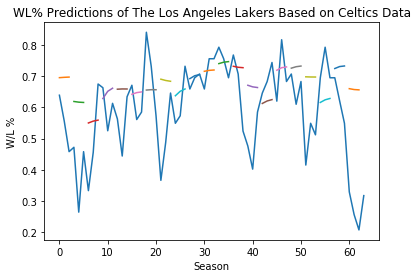

In [18]:
%matplotlib inline
predictions = predict_sequences_multiple(model, X_lal, 3, 3)
plot_results_multiple(predictions, y_lal, 3,lalseasons)

In [ ]:
np.shape(X_lal)

In [ ]:
y_lal

In [ ]:
whogotnext = np.array([np.array([.256]),np.array([.207]),np.array([.317])])

In [ ]:
whogotnext.reshape(-1,3,1)

In [ ]:
np.shape(whogotnext)

In [ ]:
model.predict(curr_frame[newaxis,:,:])[0,0]

In [ ]:
model.predict(whogotnext)

In [ ]:
newdf = newdf.dropna()

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,0], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,0],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,0], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,0], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,0], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');